In [115]:
# Standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
from jpm_time_conversions import *
from jpm_logger import JpmLogger
import peakutils.peak
from closest import closest

__author__ = 'James Paul Mason'
__contact__ = 'jmason86@gmail.com'


def light_curve_peak_match_subtract(light_curve_to_subtract_from_df, light_curve_to_subtract_with_df, estimated_time_of_peak,
                                    plots_save_path=None, verbose=False):
    """Align the peak of a second light curve to the first, scale its magnitude to match, and subtract it off.

    Inputs:
        light_curve_to_subtract_from_df [pd DataFrame]: A pandas DataFrame with a DatetimeIndex and a columns for intensity.
        light_curve_to_subtract_with_df [pd DataFrame]: A pandas DataFrame with a DatetimeIndex and a columns for intensity.
        estimated_time_of_peak [metatime]: The estimated time that the peak should occur. This could come from, e.g., GOES/XRS.
        
    Optional Inputs:
        plot_path_filename [str]: Set to a path and filename in order to save the summary plot to disk.
                                  Default is None, meaning the plot will not be saved to disk.
        verbose [bool]:           Set to log the processing messages to disk and console. Default is False.

    Outputs:
        light_curve_corrected_df [pd DataFrame]: A pandas DataFrame with the same format as light_curve_to_subtract_from_df but
                                                 with the resultant peak match and subtraction performed.
        seconds_shift [float]:                   The number of seconds that light_curve_to_subtract_with_df was shifted to get
                                                 its peak to match light_curve_to_subtract_from_df.
        scale_factor [float]:                    The multiplicative factor applied to light_curve_to_subtract_with_df to get
                                                 its peak to match light_curve_to_subtract_from_df.
                                                 
    Optional Outputs:
        None

    Example:
        light_curve_corrected_df, seconds_shift, scale_factor = light_curve_peak_match_subtract(light_curve_to_subtract_from_df, 
                                                                                                light_curve_to_subtract_with_df,
                                                                                                estimated_time_of_peak,
                                                                                                plots_save_path='./',
                                                                                                verbose=True)
    """
    return 1

In [145]:
# prototype only: set up example inputs
%matplotlib inline
estimated_time_of_peak = pd.Timestamp('2012-04-15 17:52:20.0')
plot_path_filename = './'
verbose = True

from scipy.io.idl import readsav
idl_generated_data = readsav('/Users/jmason86/Dropbox/Research/Postdoc_NASA/Analysis/Coronal Dimming Analysis/Example Dimming Light Curve.sav')
light_curve_to_subtract_from_df = pd.DataFrame({'irradiance': np.nan_to_num(idl_generated_data.irradiance[:, 3])})
light_curve_to_subtract_with_df = pd.DataFrame({'irradiance': np.nan_to_num(idl_generated_data.irradiance[:, 10])})
light_curve_to_subtract_from_df.index = yyyydoy_sod_to_datetime(idl_generated_data.yyyydoy, idl_generated_data.sod) # Convert EVE to datetime
light_curve_to_subtract_with_df.index = yyyydoy_sod_to_datetime(idl_generated_data.yyyydoy, idl_generated_data.sod) # Convert EVE to datetime
light_curve_to_subtract_from_df.head()

,irradiance
2012-04-15 17:43:20,0.246831
2012-04-15 17:44:19,0.399922
2012-04-15 17:45:18,0.275836
2012-04-15 17:46:17,0.319487
2012-04-15 17:47:16,0.920058


In [178]:
# Prepare the logger for verbose
if verbose:
    # TODO: Update the path
    logger = JpmLogger(filename='light_curve_peak_match_subtract_log', path='/Users/jmason86/Desktop/')

In [179]:
# Detrend and find the peaks that are ≥ 95% of the max intensity within
if verbose:
    logger.info("Detrending light curves.")
base_from = peakutils.baseline(light_curve_to_subtract_from_df)
detrend_from = light_curve_to_subtract_from_df - base_from
indices_from = peakutils.indexes(detrend_from.values.squeeze(), thres=0.95)

base_with = peakutils.baseline(light_curve_to_subtract_with_df)
detrend_with = light_curve_to_subtract_with_df - base_with
indices_with = peakutils.indexes(light_curve_to_subtract_with_df.values.squeeze(), thres=0.95)

# Identify the peak closest to the input estimated peak time (e.g., from GOES/XRS)
if verbose:
    logger.info("Identifying peaks closest to initial guess in light curves.")
peak_index_from = indices_from[closest(light_curve_to_subtract_from_df.index[indices_from], estimated_time_of_peak)]
peak_index_with = indices_with[closest(light_curve_to_subtract_with_df.index[indices_with], estimated_time_of_peak)]
index_shift = peak_index_from - peak_index_with

# Compute how many seconds the time shift corresponds to
seconds_shift = (light_curve_to_subtract_from_df.index[peak_index_from] - 
                 light_curve_to_subtract_with_df.index[peak_index_with]).total_seconds()

2017-12-18 15:00:32,220 [INFO ] [<module>] Detrending light curves.
2017-12-18 15:00:32,220 [INFO ] [<module>] Detrending light curves.
2017-12-18 15:00:32,252 [INFO ] [<module>] Identifying peaks closest to initial guess in light curves.
2017-12-18 15:00:32,252 [INFO ] [<module>] Identifying peaks closest to initial guess in light curves.


In [180]:
# Shift the subtract_with light curve in time to align its peak to the subtract_from light curve
if verbose:
    logger.info("Shifting and scaling the light curve to subtract with.")
shifted_with = light_curve_to_subtract_with_df.shift(index_shift)

# Scale the subtract_with light curve peak intensity to match the subtract_from light curve peak intensity
scale_factor = (detrend_from.values[peak_index_from] / shifted_with.values[peak_index_with + index_shift])[0]
shifted_scaled_with = shifted_with * scale_factor
light_curve_corrected_df = light_curve_to_subtract_from_df - shifted_scaled_with
light_curve_corrected_df.head()

if verbose:
    if light_curve_corrected_df.isnull().values.sum() > 1:
        logger.warning("%s points were shifted to become NaN." % light_curve_corrected_df.isnull().values.sum())
    logger.info("Light curve peak matching and subtraction complete.")

2017-12-18 15:00:32,643 [INFO ] [<module>] Shifting and scaling the light curve to subtract with.
2017-12-18 15:00:32,643 [INFO ] [<module>] Shifting and scaling the light curve to subtract with.
2017-12-18 15:00:32,647 [INFO ] [<module>] Light curve peak matching and subtraction complete.
2017-12-18 15:00:32,647 [INFO ] [<module>] Light curve peak matching and subtraction complete.


2017-12-18 15:00:33,352 [INFO ] [<module>] Summary plot saved to ./
2017-12-18 15:00:33,352 [INFO ] [<module>] Summary plot saved to ./


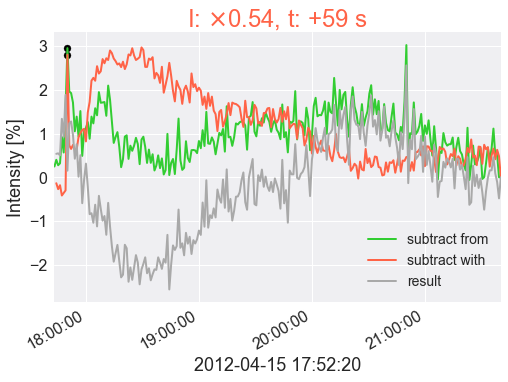

In [181]:
if plot_path_filename:
    from jpm_number_printing import latex_float
    seconds_shift_string = '+' if seconds_shift >= 0 else '-'
    seconds_shift_string += str(int(seconds_shift))
    scale_factor_string = latex_float(scale_factor)
    
    plt.style.use('jpm-light')
    from matplotlib import dates
    
    fig, ax = plt.subplots()
    plt.plot(light_curve_to_subtract_from_df.index.values, light_curve_to_subtract_from_df.values, c='limegreen')
    plt.tick_params(axis='x', which='minor', labelbottom='off')
    shifted_scaled_with.plot(c='tomato', label='subtract with', ax=ax)
    light_curve_corrected_df.plot(c='darkgrey', label='result', ax=ax)
    plt.scatter(light_curve_to_subtract_from_df.index[peak_index_from], light_curve_to_subtract_from_df.values[peak_index_from], c='black')
    plt.scatter(shifted_scaled_with.index[peak_index_with + index_shift], shifted_scaled_with.values[peak_index_with + index_shift], c='black');
    ax.legend(['subtract from', 'subtract with', 'result'], loc='best')
    plt.xlabel(estimated_time_of_peak)
    plt.ylabel('Intensity [%]')
    plt.title('I: $\\times$' + scale_factor_string + ', t: ' + seconds_shift_string + ' s', color='tomato')
    fmtr = dates.DateFormatter("%H:%M:%S")
    ax.xaxis.set_major_formatter(fmtr)
    ax.xaxis.set_major_locator(dates.HourLocator())
    plt.savefig(plot_path_filename)
    if verbose:
        logger.info("Summary plot saved to %s" % plot_path_filename)

In [182]:
return light_curve_corrected_df, seconds_shift, scale_factor

SyntaxError: 'return' outside function (<ipython-input-182-e00c6908fbed>, line 1)